In [56]:
import numpy as np
import tensorflow as tf
from tensorflow import keras, profiler
import time
import matplotlib.pyplot as plt
import torch
from tensorflow.keras import backend as K
%matplotlib inline

In [58]:
# This function consider synchronous execution and GPU aspects to measure time more accurately

def profile_inf_time(img_expanded, model):
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    repetitions = 400
    timings=np.zeros((repetitions,1))
    #GPU-WARM-UP
    for _ in range(10):
        _ = model.predict(img_expanded)
    # MEASURE PERFORMANCE
    for rep in range(repetitions):
        starter.record()
        _ = model.predict(img_expanded)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    time.sleep(1) # to avoid interference between each execution
    return mean_syn

In [59]:
# determine the memory in bytes
number_size = 4.0 # default 'float32' -> memory = 4 Bytes
if K.floatx() == 'float16':
        number_size = 2.0
if K.floatx() == 'float64':
        number_size = 8.0

In [70]:
img_size_list = []
n_params_list = []
infer_time_list = []

for i in range(1,9):
    # dummy image
    img_shape = (32*i, 32*i, 3)
    img = np.random.randint(0, 255, img_shape)
    img_expanded = np.expand_dims(img, axis=0)
    # built-in model - doesn't change no. of parameters with image shape 
    processed_img = tf.keras.applications.mobilenet.preprocess_input(img_expanded) 
    model = tf.keras.applications.mobilenet.MobileNet(input_shape = img_shape, classes=10, include_top=False, weights=None)
    # custom model
    # model = VGG16(img_shape)
    curr_time = profile_inf_time(processed_img, model)
    # get model stats
    n_params = model.count_params()
    print(f"Image shape:{img_shape[0]},\t No. of params:{n_params},\t Memory:{n_params * number_size},\t Inference time:{curr_time}")
    # append to list
    img_size_list.append(img_shape[0])
    n_params_list.append(n_params)
    infer_time_list.append(curr_time)

Image shape:32,	 No. of params:3228864,	 Memory:12915456.0,	 Inference time:58.970043878555295
Image shape:64,	 No. of params:3228864,	 Memory:12915456.0,	 Inference time:59.356143922805785
Image shape:96,	 No. of params:3228864,	 Memory:12915456.0,	 Inference time:59.26606282234192
Image shape:128,	 No. of params:3228864,	 Memory:12915456.0,	 Inference time:62.28873161315918
Image shape:160,	 No. of params:3228864,	 Memory:12915456.0,	 Inference time:62.884392251968386
Image shape:192,	 No. of params:3228864,	 Memory:12915456.0,	 Inference time:67.97031136512756
Image shape:224,	 No. of params:3228864,	 Memory:12915456.0,	 Inference time:69.43456394195556
Image shape:256,	 No. of params:3228864,	 Memory:12915456.0,	 Inference time:68.25839498519898


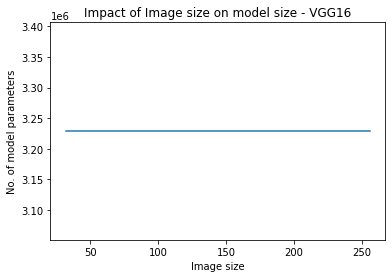

In [72]:
plt.plot(img_size_list, n_params_list)
plt.xlabel("Image size")
plt.ylabel("No. of model parameters")
plt.title("Impact of Image size on model size - VGG16")
plt.show()

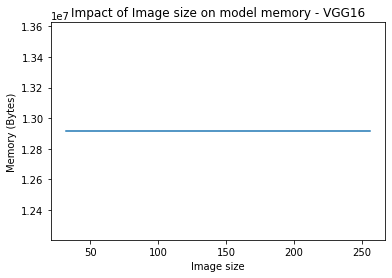

In [73]:
memory_list = [p * number_size for p in n_params_list]
plt.plot(img_size_list, memory_list)
plt.xlabel("Image size")
plt.ylabel("Memory (Bytes)")
plt.title("Impact of Image size on model memory - VGG16")
plt.show()

# At max we reached 88.25 MB

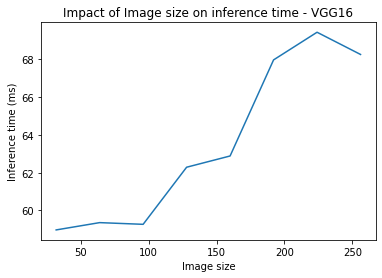

In [74]:
plt.plot(img_size_list, infer_time_list)
plt.xlabel("Image size")
plt.ylabel("Inference time (ms)")
plt.title("Impact of Image size on inference time - VGG16")
plt.show()

### Investigating the impact layer

In [75]:
i=1
img_shape = (32*i, 32*i, 3) 
model = tf.keras.applications.mobilenet.MobileNet(input_shape = img_shape, classes=10, include_top=False, weights=None)
model.summary()

Model: "mobilenet_1.00_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                          

In [71]:
i=4
img_shape = (32*i, 32*i, 3) # 128 x 128
model = tf.keras.applications.mobilenet.MobileNet(input_shape = img_shape, classes=10, include_top=False, weights=None)
model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         